# Hyperparameter optimisation of a Gaussian Process

In [2]:
%pip install GPyOpt
%pip install emukit

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pylab inline
import GPy
import GPyOpt
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd

from numpy.random import seed
from scipy.stats import multivariate_normal as mvn

warnings.filterwarnings('ignore')
seed(12345)

from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper

Populating the interactive namespace from numpy and matplotlib


## Load the data

In [27]:
pr_df = pd.read_csv("51875_09375.csv")

training_set = pr_df.iloc[0:80]
test_set = pr_df.iloc[80:100]

In [196]:
x_train = np.linspace(1, 80, 80)

# Renormalise it since they're all approximately *10^-5
y_train = (training_set["pr"].to_numpy())*10**5

x_test = np.linspace(80, 100, 20)
y_test = test_set["pr"].to_numpy()*10**5

x_train.shape, y_train.shape

((80,), (80,))

---

In [641]:
pr_df = pd.read_csv("test-ts.csv")

start = 1400
end = 1700
test_end = 1980

training_set = pr_df.iloc[start:end]
test_set = pr_df.iloc[end:test_end]

In [642]:
x_train = np.linspace(1, end-start, end-start)

# Renormalise it since they're all approximately *10^-5
y_train = (training_set["1"].to_numpy())

x_test = np.linspace(end-start, test_end-start, test_end-end)
y_test = test_set["1"].to_numpy()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((300,), (300,), (280,), (280,))

In [643]:
x_all = np.linspace(1, test_end-start, test_end-start).reshape(-1,1)
x_plot = (np.arange(test_end-start) + 1).reshape(-1,1)
print(len(x_plot))

580


In [644]:
# normalize
y_mean = np.mean(y_train)
#y_train = y_train - y_mean
#y_test = y_test - y_mean

## Fit a GP to this data

In [645]:
import matplotlib.pyplot as plt

from matplotlib import colors as mcolors
from matplotlib import cm

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [671]:
def helper_plot_emulator_errorbars():
    """Helper function for plotting the emulator fit."""
    ax.plot(emukit_model.X, emukit_model.Y+y_mean, 'ro', markersize=3, label='train',color='orange')
    ax.plot(x_plot, mu_plot, 'C0', label='model', linewidth=3)
    ax.plot(x_test, y_test, 'ro', markersize=3, label='test')
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color='C0', alpha=0.6)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.4)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.2)
    ax.legend(loc=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax.grid(True)
    #ax.set_xlim(0, 100)
    ax.set_ylim([260, 300])

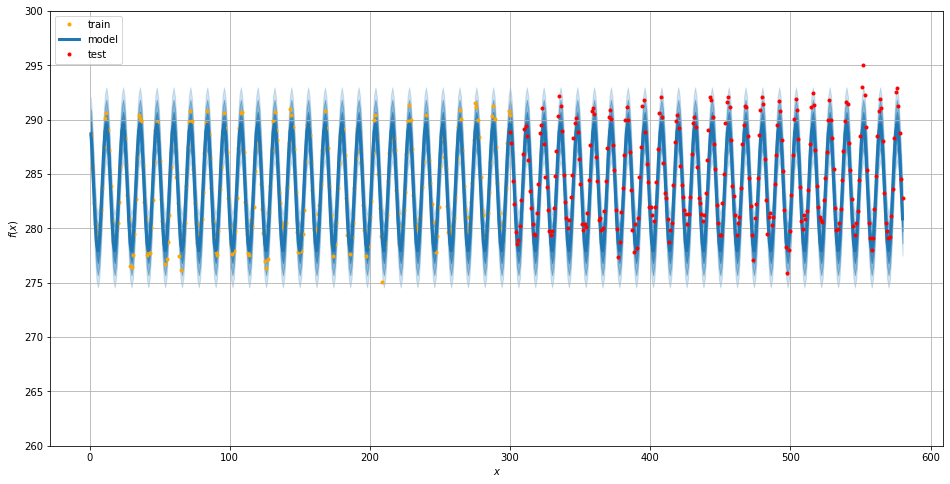

In [672]:
#kern = GPy.kern.RBF(1, lengthscale=0.1, variance=0.1)
#kern = GPy.kern.RBF(1, lengthscale=2.6, variance=3.5) + GPy.kern.StdPeriodic(1, lengthscale=1.0) * GPy.kern.PeriodicMatern32(1, lengthscale=10, variance=3.5)
# kern = GPy.kern.RBF(1, lengthscale=2.6, variance=3.5) +  GPy.kern.RBF(1, lengthscale=2.6, variance=3.5) * GPy.kern.Cosine(1, lengthscale=0.1, variance=2) 

#kern = GPy.kern.RBF(1, lengthscale=10, variance=3.5) + (GPy.kern.RBF(1, lengthscale=10, variance=10) * GPy.kern.Cosine(1, lengthscale=0.1, variance=10)) + GPy.kern.sde_RatQuad(1, lengthscale=1, variance=10) + (GPy.kern.RBF(1, lengthscale=1, variance=1)*GPy.kern.sde_White(1,variance=0.01)) 

#kern = GPy.kern.RBF(1, lengthscale=20, variance=1) + (GPy.kern.RBF(1, lengthscale=10, variance=1) * GPy.kern.Cosine(1, lengthscale=0.1, variance=1)) + GPy.kern.sde_RatQuad(1, lengthscale=1, variance=10)
kern = GPy.kern.Cosine(1, lengthscale=0.1, variance=1)

#kern = GPy.kern.RBF(1, lengthscale=10) + (GPy.kern.RBF(1, lengthscale=10) * (GPy.kern.PeriodicExponential(1, lengthscale=100, period=1) + GPy.kern.sde_RatQuad(1, lengthscale=10))) + (GPy.kern.RBF(1, lengthscale=10, variance=10)*GPy.kern.sde_White(1,variance=0.01)) 
gpy_model = GPy.models.GPRegression(x_train.reshape(-1,1), y_train.reshape(-1,1)-y_mean, kern, noise_var=1e-10)
emukit_model = GPyModelWrapper(gpy_model)

emukit_model.optimize()

mu_plot, var_plot = emukit_model.predict(x_plot)
mu_plot += y_mean

fig, ax = plt.subplots(figsize=(16,8))
helper_plot_emulator_errorbars()
plt.show()

## OG

In [252]:
#kernel = GPy.kern.RBF(1, lengthscale=2.6, variance=3.5) + GPy.kern.StdPeriodic(1, lengthscale=1.0) * GPy.kern.PeriodicMatern32(1, lengthscale=10, variance=3.5)
#kernel = GPy.kern.RBF(1, lengthscale=10, variance=3.5) + (GPy.kern.RBF(1, lengthscale=10, variance=10) * GPy.kern.Cosine(1, lengthscale=0.1, variance=10)) + GPy.kern.sde_RatQuad(1, lengthscale=1, variance=10) + (GPy.kern.RBF(1, lengthscale=1, variance=1)*GPy.kern.sde_White(1,variance=0.01))
kernel = GPy.kern.RBF(1, lengthscale=10, variance=1) + (GPy.kern.RBF(1, lengthscale=100, variance=10) * (GPy.kern.PeriodicExponential(1, lengthscale=0.1, variance=1, period=10) + GPy.kern.sde_RatQuad(1, lengthscale=10, variance=1))) + (GPy.kern.RBF(1, lengthscale=1, variance=1)*GPy.kern.sde_White(1,variance=0.01)) 
model = GPy.models.GPRegression(x_train.reshape(-1, 1), y_train.reshape(-1, 1), kernel=kernel, normalizer=False, noise_var=0.05)

In [253]:
display(model)

GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,10.0,+ve,
sum.mul.rbf.variance,10.0,+ve,
sum.mul.rbf.lengthscale,100.0,+ve,
sum.mul.sum.periodic_exponential.variance,1.0,+ve,
sum.mul.sum.periodic_exponential.lengthscale,0.1,+ve,
sum.mul.sum.periodic_exponential.period,10.0,+ve,
sum.mul.sum.RatQuad.variance,1.0,+ve,
sum.mul.sum.RatQuad.lengthscale,10.0,+ve,
sum.mul.sum.RatQuad.power,2.0,+ve,


Find a measure of the loss, e.g. RMSE, using the default parameters.

In [254]:
#x_all = np.linspace(1, 100, 100)
y_mean, y_std = model.predict(x_all.reshape(-1, 1))

ValueError: 'x' is not 1-dimensional

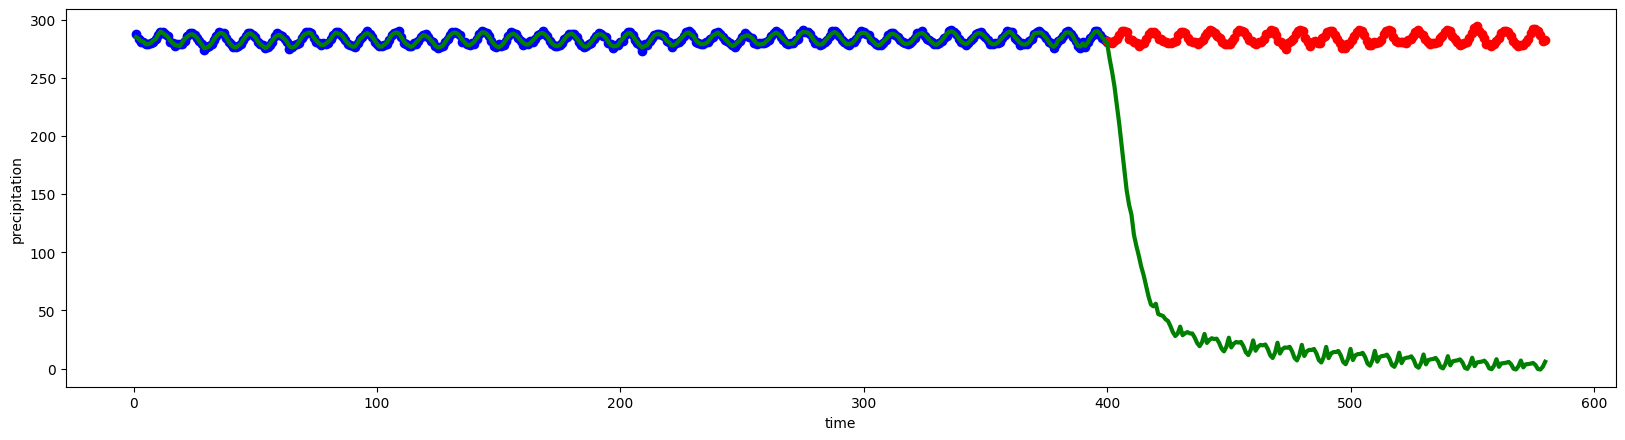

In [257]:
plt.figure(figsize=(20, 5), dpi=100)
plt.xlabel("time")
plt.ylabel("precipitation")
plt.scatter(x_train, y_train, lw=1, color="b", label="training dataset")
plt.scatter(x_test, y_test, lw=1, color="r", label="testing dataset")
plt.plot(x_all, y_mean, lw=3, color="g", label="GP mean")
plt.fill_between(x_all, (y_mean + y_std).reshape(y_mean.shape[0]), (y_mean - y_std).reshape(y_mean.shape[0]), facecolor="b", alpha=0.3, label="confidence")
plt.legend(loc="upper left")
plt.xlim(70, 100)
plt.ylim(-50, 50)
plt.show()

In [258]:
# Make some predictions by drawing from the distributions 
# the GP has returned for all values (the first 80 were
# actually in the training set, the rest only test set.)
def draw_samples(y_mean, y_std):
    mean = y_mean.reshape(-1)
    cov = np.diag(y_std.reshape(-1))
    y_pred = mvn.rvs(mean, cov, 1)

    return y_pred

In [259]:
def fit_gp(x):
    # x are the hyperparameters: ls1, ls2, v1, v2.
    
    rmse = 0
    for i in range(x.shape[0]):
        #kernel = GPy.kern.RBF(1, lengthscale=x[i, 0], variance=x[i, 3]) + GPy.kern.StdPeriodic(1, lengthscale=x[i, 1]) * GPy.kern.PeriodicMatern32(1, lengthscale=x[i, 2], variance=x[i, 4])
        kernel = GPy.kern.RBF(1, lengthscale=x[i, 0], variance=x[i, 1]) + (GPy.kern.RBF(1, lengthscale=x[i, 2], variance=x[i, 3]) * GPy.kern.Cosine(1, lengthscale=x[i, 4], variance=x[i, 5])) + GPy.kern.sde_RatQuad(1, lengthscale=x[i, 6], variance=x[i, 7])
        print(x_train, y_train)
        model = GPy.models.GPRegression(x_train.reshape(-1, 1), y_train.reshape(-1, 1), kernel=kernel, normalizer=False, noise_var=0.05)
        y_mean, y_std = model.predict(x_all.reshape(-1, 1))
        y_pred = draw_samples(y_mean, y_std)
        
        # Calculate RMSE — does it even make sense to use RMSE since
        # a GP doesn't make exact predictions, but specifies distributions
        # over functions?
        all_y = np.concatenate([y_train, y_test])
        rmse += np.sum(all_y - y_pred)

    return rmse

In [313]:
domain = [
    {'name': 'lengthscale1', 'type': 'continuous', 'domain': (0.,10.)},
    {'name': 'variance1', 'type': 'continuous', 'domain': (0.,10.)},
    {'name': 'lengthscale2', 'type': 'continuous', 'domain': (0.,10.)},
    {'name': 'variance2', 'type': 'continuous', 'domain': (0.,10.)},
    {'name': 'lengthscale3', 'type': 'continuous', 'domain': (0.,10.)},
    {'name': 'variance3', 'type': 'continuous', 'domain': (0.,10.)},
    {'name': 'lengthscale4', 'type': 'continuous', 'domain': (0.,10.)},
    {'name': 'variance4', 'type': 'continuous', 'domain': (0.,10.)}]

We, then, create the GPyOpt object and run the optimization procedure. It might take a while.

In [314]:
opt = GPyOpt.methods.BayesianOptimization(f = fit_gp,            # function to optimize       
                                          domain = domain,         # box-constraints of the problem
                                          acquisition_type ='LCB',       # LCB acquisition
                                          acquisition_weight = 0.1)   # Exploration exploitation

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 76. 77. 78. 79. 80.] [ 0.37651729  0.18280949 -0.05510291 -1.57808356 -0.45598961 -2.10654113
 -0.79586921  0.01235289 -1.44098901 -1.93029601  0.02952159  0.36987399
  1.14785829 -0.77891751 -0.04467901 -0.57727131  1.29352909 -1.93925243
 -0.04060031 -1.25194231 -0.89402551  1.44175529  0.54553509  1.13349749
  0.31735229  0.51691349 -0.93388581 -0.66829371 -1.15704286 -0.26089591
 -0.24811311  3.25824909 -0.28299681 -0.92641841  0.35511149  0.46885589
 -0.96581631  0.10528119  0.07179089 -0.51911961 -1.59912181  0.91978549
  0.12478929 -1.65018598 -1.62952081  8.24853409 -0.09936041  1.65142189
  0.84319029  1.11949299 -0.93179276  0.26800169 -1.51686641 -1.41857274
 -1.47035428 -1.5

In [ ]:
# it may take a few seconds
opt.run_optimization(max_iter=50)
opt.plot_convergence()

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 76. 77. 78. 79. 80.] [ 0.37651729  0.18280949 -0.05510291 -1.57808356 -0.45598961 -2.10654113
 -0.79586921  0.01235289 -1.44098901 -1.93029601  0.02952159  0.36987399
  1.14785829 -0.77891751 -0.04467901 -0.57727131  1.29352909 -1.93925243
 -0.04060031 -1.25194231 -0.89402551  1.44175529  0.54553509  1.13349749
  0.31735229  0.51691349 -0.93388581 -0.66829371 -1.15704286 -0.26089591
 -0.24811311  3.25824909 -0.28299681 -0.92641841  0.35511149  0.46885589
 -0.96581631  0.10528119  0.07179089 -0.51911961 -1.59912181  0.91978549
  0.12478929 -1.65018598 -1.62952081  8.24853409 -0.09936041  1.65142189
  0.84319029  1.11949299 -0.93179276  0.26800169 -1.51686641 -1.41857274
 -1.47035428 -1.5

LinAlgError: SVD did not converge

Let's show the best parameters found. They differ significantly from the default parameters.

In [ ]:
optimal_hparams = opt.X[np.argmin(opt.Y)]
print(f"ls1: {str(optimal_hparams[0])}, ls2: {str(optimal_hparams[1])}, ls3: {str(optimal_hparams[2])}, v1: {str(optimal_hparams[3])}, v2: {str(optimal_hparams[4])}\n")

In [ ]:
kernel = GPy.kern.RBF(1, lengthscale=optimal_hparams[0], variance=optimal_hparams[3]) + \
             GPy.kern.StdPeriodic(1, lengthscale=optimal_hparams[1]) * \
             GPy.kern.PeriodicMatern32(1, lengthscale=optimal_hparams[2], variance=optimal_hparams[4])

model = GPy.models.GPRegression(x_train.reshape(-1, 1), y_train.reshape(-1, 1), kernel=kernel, normalizer=True,
                                noise_var=0.05)
y_mean, y_std = model.predict(x_all.reshape(-1, 1))

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.xlabel("time")
plt.ylabel("precipitation")
plt.scatter(x_train, y_train, lw=1, color="b", label="training dataset")
plt.scatter(x_test, y_test, lw=1, color="r", label="testing dataset")
plt.plot(x_all, y_mean, lw=3, color="g", label="GP mean")
plt.fill_between(x_all, (y_mean + y_std).reshape(y_mean.shape[0]), (y_mean - y_std).reshape(y_mean.shape[0]), facecolor="b", alpha=0.3, label="confidence")
plt.legend(loc="upper left")
plt.xlim(70, 100)
plt.show()